# Experiment - Ignore

In [1]:
import torch
from torch.autograd import grad
from torch.autograd.functional import jacobian

# Define the function f
def f(x, t):
    return x**2 - t**3 + x*t
 
# Create a tensor x and set
# requires_grad=True to track the gradient
x = torch.tensor([[2.0], [1.0], [0.5]], requires_grad=True)
t = torch.tensor([[-1.0], [3.0], [0.0]], requires_grad=True)

z = f(x,t).sum()

grad_f = grad(z, (x,t), create_graph=True, allow_unused=True)
print("First order derivative: (First value is w.r.t x and then t)\n", grad_f)
print("---------------")

out = torch.empty([3, 1])
grad_grad_fx = grad([grad_f[0][i] for i in range(3)], inputs=(x,t), create_graph=True, allow_unused=True)
print("HERE", grad_grad_fx)

for i in range(3):
    grad_grad_fx = grad(grad_f[0][i], inputs=(x,t), create_graph=True, allow_unused=True)
    # print("Second order derivative w.r.t x: (First value is w.r.t x and then t)\n", [x[i] for x in grad_grad_fx][0])
    grad_grad_ft = grad(grad_f[1][i], inputs=(x,t), create_graph=True, allow_unused=True)
    # print("Second order derivative w.r.t t: (First value is w.r.t x and then t)\n", [x[i] for x in grad_grad_ft][1])
    print([x[i] for x in grad_grad_ft][1] + [x[i] for x in grad_grad_fx][0])
    out[i] = [x[i] for x in grad_grad_ft][1] + [x[i] for x in grad_grad_fx][0]
    
print(out)
print(out.shape)


First order derivative: (First value is w.r.t x and then t)
 (tensor([[3.],
        [5.],
        [1.]], grad_fn=<AddBackward0>), tensor([[ -1.0000],
        [-26.0000],
        [  0.5000]], grad_fn=<AddBackward0>))
---------------
HERE (tensor([[2.],
        [2.],
        [2.]], grad_fn=<MulBackward0>), tensor([[1.],
        [1.],
        [1.]]))
tensor([8.], grad_fn=<AddBackward0>)
tensor([-16.], grad_fn=<AddBackward0>)
tensor([2.], grad_fn=<AddBackward0>)
tensor([[  8.],
        [-16.],
        [  2.]], grad_fn=<CopySlices>)
torch.Size([3, 1])


# Start of PINNS

In [2]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.autograd import grad
import matplotlib.pyplot as plt

import numpy as np

# Set default dtype to float32
torch.set_default_dtype(torch.float)

# PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

"""
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

"""


"\n# Device configuration\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\nprint(device)\n\nif device == 'cuda':\n    print(torch.cuda.get_device_name())\n\n"

## Equations at hand

||Equation|
|-|-|
|Differential equation|$\nabla^2\Psi(x,y) = \mathrm{e}^{-x}(x - 2 + y^3 + 6y)$|
|Trial solution:|$\Psi(x,y)_t = N(x,y,p)$|
|$A(x, y)$|$(1 − x)y^3 + x(1 + y^3)\mathrm{e}^{−1} + (1 − y)x(\mathrm{e}^{−x} − \mathrm{e}^{−1}) + y[(1 + x)\mathrm{e}^{−x} − (1 − x − 2x\mathrm{e}^{−1})]$|
|Analytical solution|$\Psi(x,y)_a = \mathrm{e}^{−x}(x + y^3)$|
|Dirichlet BCs| $\Psi(0, y) = y^3, \Psi(1, y) = (1 + y^3)e^{−1}$|
|| $\Psi(x, 0) = xe^{(-x)}, \Psi(x, 1) = e^{(-x)}(x + 1)$|

## Needed funcs

In [3]:
def analytic_solution(x,y):
    return np.exp(-x)*(x+(y**3))

def A(x,y):
    return (1-x)* y**3 + x*(1+y**3)*torch.exp(torch.tensor(-1)) + (1-y)* x *(torch.exp(-x) - torch.exp(torch.tensor(-1))) + y*((1+x)*torch.exp(-x) - (1-x-2*x*torch.exp(torch.tensor(-1))))

def rhs_of_differential_equation(x,y):
    return np.exp(-1)*(x-2+y**3+6*y)


## NN class

In [4]:
class FCN(nn.Module):
    ##  Neural Network
    def __init__(self, layers):
        super().__init__() #call __init__ from parent class
        self.flatten = nn.Flatten()
        self.loss_function = nn.MSELoss(reduction ='mean')
        # Adding number of layers as in `layers` variable from control
        self.layers = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
        
    def forward(self, point):
        X_Y = torch.hstack(point)
        nn_output = self.layers(X_Y)
        return nn_output

    def trial_eqn(self, x, y):
        return self.forward((x, y))
        # return A(x, y) + x*(1-x)*y*(1-y)*self.forward(point)
    
    # Loss function is (trial_eqn - RHS_of_orginal_diff_eqn)**2
    # def loss(self, point):
    #     X,Y = point        
    #     z = self.trial_eqn(point).sum()
        
    #     grad_trial_eqn = grad(z, (X, Y), create_graph=True, allow_unused=True)
        
    #     dff_psi = torch.empty([X.shape[0], 1])
    #     for i in range(X.shape[0]):
    #         grad_grad_fx = grad(grad_trial_eqn[0][i], inputs=(X,Y), create_graph=True, allow_unused=True)
    #         grad_grad_fy = grad(grad_trial_eqn[1][i], inputs=(X,Y), create_graph=True, allow_unused=True)
            
    #         dff_psi[i] = [x[i] for x in grad_grad_fy][1] + [x[i] for x in grad_grad_fx][0]
    #     expected_output = rhs_of_differential_equation(X,Y)
    #     return self.loss_function(dff_psi, expected_output)
    
    def loss_pde(self, point):
        x, y = point
        z = self.trial_eqn(x, y).sum()
        grad_trial_eqn = grad(z, (x, y), create_graph=True, allow_unused=True)
        
        dff_psi = torch.empty([x.shape[0], 1])
        for i in range(x.shape[0]):
            grad_grad_fx = grad(grad_trial_eqn[0][i], inputs=(x,y), create_graph=True, allow_unused=True)
            grad_grad_fy = grad(grad_trial_eqn[1][i], inputs=(x,y), create_graph=True, allow_unused=True)
            
            dff_psi[i] = [x[i] for x in grad_grad_fy][1] + [x[i] for x in grad_grad_fx][0]
        expected_output = rhs_of_differential_equation(x, y)
        return self.loss_function(dff_psi, expected_output)
    
    def loss_bc(self, point):
        x, y = point
        # print(type(x), type(y))
        # print(len(x), len(y))
        zeros = torch.zeros(x.shape[0],1)
        ones = torch.ones(x.shape[0],1)
        loss1 = self.loss_function(self.trial_eqn(zeros, y), y**3)
        loss2 = self.loss_function(self.trial_eqn(ones, y), (1+y**3)*torch.exp(torch.tensor(-1)))
        loss3 = self.loss_function(self.trial_eqn(x, zeros), (x*torch.exp(-x)))
        loss4 = self.loss_function(self.trial_eqn(x, ones), torch.exp(-x)*(x+1))
        
        return (loss1+loss2+loss3+loss4)
        
    
    def loss_new_appoach(self, point):
        pde_loss = self.loss_pde(point)
        bc_loss = self.loss_bc(point)
        
        return pde_loss + bc_loss

# Generate data

In [5]:
steps = 1000
lr = 0.02
layers = np.array([]) # layers

# To generate new data:
x_min = 0
x_max = 1
y_min = 0
y_max = 1

total_points_x_y = 100

In [6]:
X_ = torch.linspace(x_min, x_max, total_points_x_y, requires_grad=True).view(-1,1)
Y_ = torch.linspace(y_min, y_max, total_points_x_y, requires_grad=True).view(-1,1)

X, Y = torch.meshgrid(X_.squeeze(1), Y_.squeeze(1))

print(f"Generating {total_points_x_y} of x and y")
print(f"Shape of generated data: {X.shape}")

Generating 100 of x and y
Shape of generated data: torch.Size([100, 100])


c:\Users\varun\.conda\envs\nn_de\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
X.shape

torch.Size([100, 100])

# Model training and eval

In [8]:
#Create Model
PINN = FCN(layers)
optimizer = torch.optim.SGD(PINN.parameters(), lr=lr)

In [9]:
print(PINN)

FCN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (loss_function): MSELoss()
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [10]:
import matplotlib.pyplot as plt

In [11]:
def plot3d(dim1, dim2, output):
    '''
    dim1 : n, m
    dim2: n, m
    output: n, m
    '''
    axes = [item if not isinstance(item, torch.Tensor) else item.detach().numpy() for item in [dim1, dim2, output]]
    
    ax = plt.axes(projection='3d')
    ax.plot_surface(axes[1], axes[0], axes[2], cmap="rainbow")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('psi(x,y)')

    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


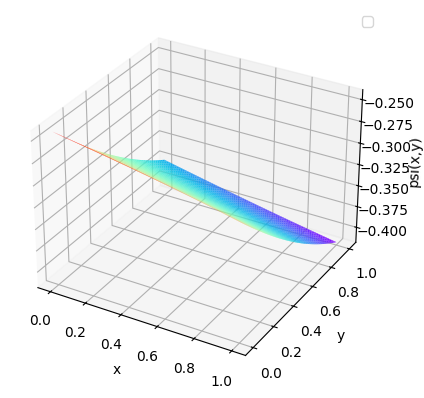

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


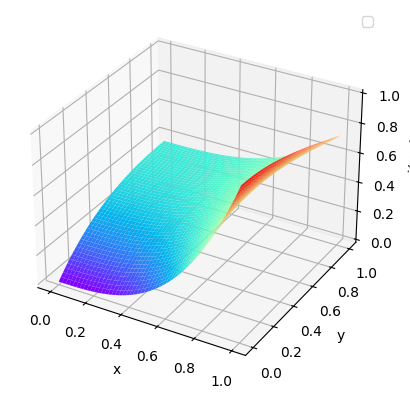

In [12]:
true_psi = analytic_solution(X.detach().numpy(), Y.detach().numpy())    # (n, n)
input_X, input_Y = X.transpose(1,0).flatten()[:,None], Y.transpose(1,0).flatten()[:,None]   # Both (n*n, 1)
initial_model_output = PINN.trial_eqn(input_X, input_Y)     # (n*n, 1)
initial_model_output = initial_model_output.reshape(shape=[total_points_x_y, total_points_x_y]).transpose(1,0) # Reshaped to (n,n)

plot3d(X, Y, initial_model_output)  # (n,n)(n,n)(n,n)
plot3d(X, Y, true_psi)  # (n,n)(n,n)(n,n)

In [13]:
PINN.train()
for i in range(steps):
    if i==0:
        print("Training Loss")
    loss = PINN.loss_new_appoach((X_, Y_))
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()
    
    if i%(steps//20) == 0:
        print(i, loss.detach().cpu().numpy())

Training Loss


0 4.0233383
50 0.6686783
100 2.5466387
150 0.16023244
200 0.16663119
250 0.148973
300 0.13818245
350 0.12957242
400 0.12132033
450 0.113158956
500 0.10501467
550 0.09686017
600 0.08870545
650 0.08058973
700 0.07257409
750 0.06473843
800 0.05717375
850 0.049965896
900 0.043182287
950 0.0368627


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


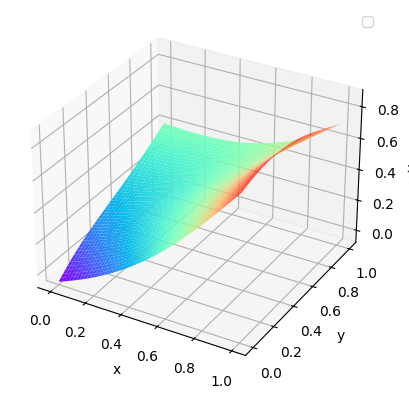

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


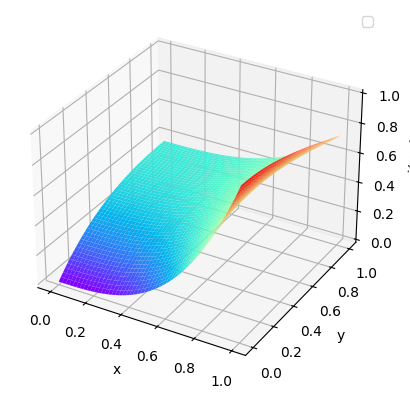

In [14]:
input_X, input_Y = X.transpose(1,0).flatten()[:,None], Y.transpose(1,0).flatten()[:,None]   # Both (n*n, 1)
final_model_output = PINN.trial_eqn(input_X, input_Y) 
final_model_output = final_model_output.reshape(shape=[total_points_x_y, total_points_x_y]).transpose(1,0) # Reshaped to (n,n)

plot3d(X, Y, final_model_output)
plot3d(X, Y, true_psi)